# Red para clasificar los números dibujados

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

torch.nn es para neural networks
torch.optim es para los optimizadores
torchvision contiene datasets, modelos, y transofrmación de imágenes para vision computacional  
* datasets es para las bases de datos
* transforms es para transformar las imágenes en un formato para entrenamiento
torch.utils.data es una clase que itera la lectura de los datasets

In [2]:
# Configuración de transformación de datos para el conjunto MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalización
])

Se usa compose para hacer varias transformaciones juntas

In [3]:
# Carga del conjunto de datos MNIST
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

In [4]:
# Dividir el conjunto de entrenamiento en entrenamiento y validación
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [5]:
# Crear cargadores de datos
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

## Primera prueba con dropout
Se busca mejorar el accuracy y reducir el valor de pérdida

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout1(x)
        x = self.activation(self.fc2(x))
        x = self.dropout2(x)
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

In [7]:
# Instanciar el modelo
input_size = 28 * 28
hidden_sizes = [512, 256, 128]
output_size = 10

model_1 = NeuralNetwork(input_size, hidden_sizes, output_size)

In [8]:
# Configurar el optimizador y la función de pérdida

# Definir los parámetros del optimizador
learning_rate = 0.000005
beta_1 = 0.8
beta_2 = 0.999
epsilon = 1e-10

# Crear el optimizador Adam con los parámetros especificados
custom_optimizer = optim.Adam(model_1.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=epsilon)
criterion = nn.CrossEntropyLoss()  # Pérdida para clasificación

In [9]:
# Función para entrenar el modelo con métricas y guardado del mejor modelo
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()
        
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Evaluación en validación
        model_1.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        epoch_time = time.time() - start_time
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Time: {epoch_time:.2f}s")
        
        # Guardar el mejor modelo basado en pérdida de validación
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "Modelo_dropout.pth")
            print("Model saved!")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [14]:
# Función para evaluar el modelo
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {accuracy:.4f}")
    return accuracy

In [11]:
# Entrenar el modelo
epochs = 60
train_losses_1, val_losses_1, train_accuracies_1, val_accuracies_1 = train_model(model_1, train_loader, val_loader, custom_optimizer, criterion, epochs)

Epoch 1/60 - Train Loss: 1.7644, Train Acc: 0.4862, Val Loss: 1.0004, Val Acc: 0.7719, Time: 77.55s
Model saved!
Epoch 2/60 - Train Loss: 0.8601, Train Acc: 0.7552, Val Loss: 0.5965, Val Acc: 0.8394, Time: 72.67s
Model saved!
Epoch 3/60 - Train Loss: 0.6158, Train Acc: 0.8196, Val Loss: 0.4700, Val Acc: 0.8704, Time: 55.87s
Model saved!
Epoch 4/60 - Train Loss: 0.5161, Train Acc: 0.8479, Val Loss: 0.4139, Val Acc: 0.8800, Time: 53.56s
Model saved!
Epoch 5/60 - Train Loss: 0.4601, Train Acc: 0.8643, Val Loss: 0.3757, Val Acc: 0.8901, Time: 53.79s
Model saved!
Epoch 6/60 - Train Loss: 0.4210, Train Acc: 0.8746, Val Loss: 0.3516, Val Acc: 0.8972, Time: 55.03s
Model saved!
Epoch 7/60 - Train Loss: 0.3915, Train Acc: 0.8835, Val Loss: 0.3315, Val Acc: 0.9003, Time: 61.77s
Model saved!
Epoch 8/60 - Train Loss: 0.3701, Train Acc: 0.8905, Val Loss: 0.3145, Val Acc: 0.9060, Time: 98.89s
Model saved!
Epoch 9/60 - Train Loss: 0.3520, Train Acc: 0.8964, Val Loss: 0.3027, Val Acc: 0.9095, Time: 58.

In [12]:
# Evaluar el modelo en el conjunto de prueba
accuracy = evaluate_model(model_1, test_loader, criterion)

Test Loss: 0.0856, Accuracy: 0.9728


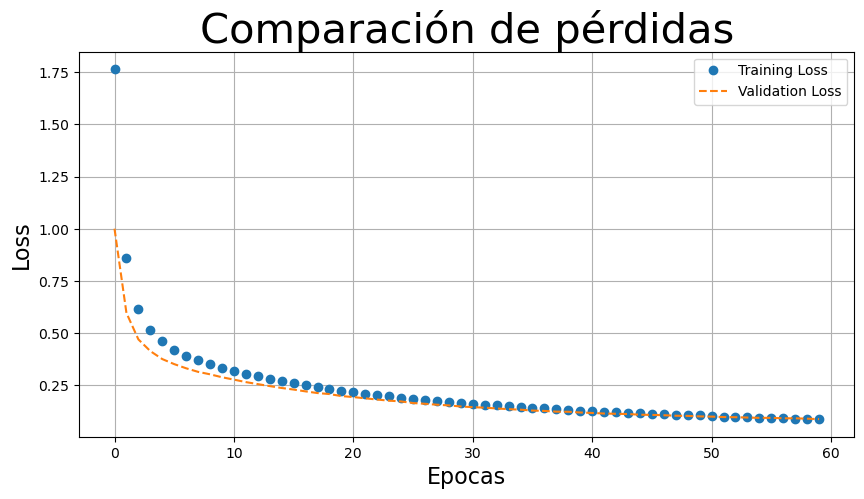

In [ ]:
# Graficar las pérdidas
plt.figure(figsize=(10, 5))
plt.plot(train_losses_1, "o", label="Training Loss")
plt.plot(val_losses_1, "--", label="Validation Loss")

plt.ylabel("Loss", fontsize = 16)
plt.xlabel("Epocas", fontsize = 16)
plt.legend()
plt.title("Comparación de pérdidas", fontsize = 30)

plt.grid()
plt.show()

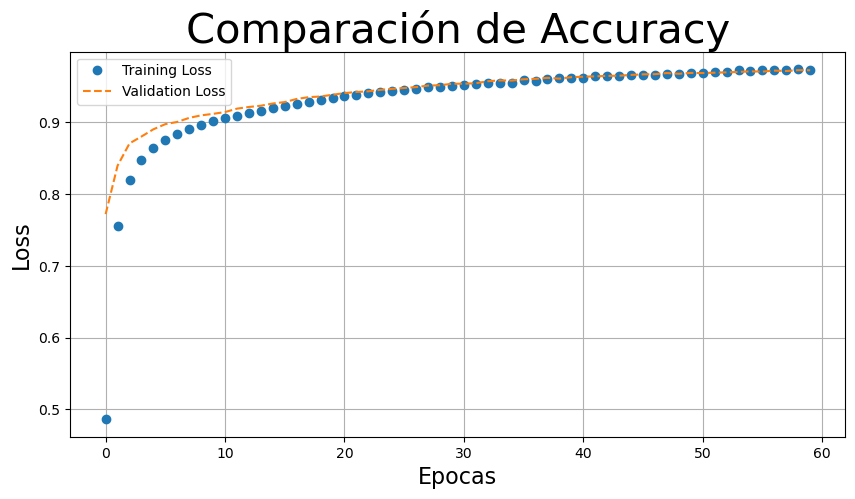

In [33]:
# Graficar las pérdidas
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies_1, "o", label="Training Loss")
plt.plot(val_accuracies_1, "--", label="Validation Loss")

plt.ylabel("Loss", fontsize = 16)
plt.xlabel("Epocas", fontsize = 16)
plt.legend()

#Ejes
plt.title("Comparación de Accuracy", fontsize = 30)

plt.grid()
plt.show()

## Segunda prueba. Usando L2
Mismo propósito, mejorar accuracy y reducir loss

In [19]:
class NeuralNetwork_2(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork_2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

In [20]:
# Función para entrenar el modelo con métricas y guardado del mejor modelo
def train_model_2(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()
        
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Evaluación en validación
        model_1.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        epoch_time = time.time() - start_time
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Time: {epoch_time:.2f}s")
        
        # Guardar el mejor modelo basado en pérdida de validación
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "Modelo_L2.pth")
            print("Model saved!")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [21]:
# Instanciar el modelo
input_size = 28 * 28
hidden_sizes = [512, 256, 128]
output_size = 10

model2 = NeuralNetwork_2(input_size, hidden_sizes, output_size)

# Configurar el optimizador y la función de pérdida

# Definir los parámetros del optimizador
learning_rate = 0.000005
beta_1 = 0.8
beta_2 = 0.999
epsilon = 1e-10

# Crear el optimizador Adam con los parámetros especificados
custom_optimizer = optim.Adam(model2.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=epsilon, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()  # Pérdida para clasificación

In [22]:
# Entrenar el modelo
epochs = 60
train_losses_2, val_losses_2, train_accuracies_2, val_accuracies_2 = train_model_2(model2, train_loader, val_loader, custom_optimizer, criterion, epochs)

Epoch 1/60 - Train Loss: 1.4370, Train Acc: 0.6557, Val Loss: 0.7617, Val Acc: 0.8147, Time: 55.73s
Model saved!
Epoch 2/60 - Train Loss: 0.5967, Train Acc: 0.8479, Val Loss: 0.4976, Val Acc: 0.8643, Time: 54.13s
Model saved!
Epoch 3/60 - Train Loss: 0.4484, Train Acc: 0.8779, Val Loss: 0.4155, Val Acc: 0.8843, Time: 55.59s
Model saved!
Epoch 4/60 - Train Loss: 0.3903, Train Acc: 0.8909, Val Loss: 0.3731, Val Acc: 0.8937, Time: 56.37s
Model saved!
Epoch 5/60 - Train Loss: 0.3574, Train Acc: 0.8979, Val Loss: 0.3497, Val Acc: 0.8976, Time: 54.45s
Model saved!
Epoch 6/60 - Train Loss: 0.3351, Train Acc: 0.9038, Val Loss: 0.3310, Val Acc: 0.9022, Time: 54.42s
Model saved!
Epoch 7/60 - Train Loss: 0.3170, Train Acc: 0.9093, Val Loss: 0.3143, Val Acc: 0.9067, Time: 53.61s
Model saved!
Epoch 8/60 - Train Loss: 0.3019, Train Acc: 0.9132, Val Loss: 0.3025, Val Acc: 0.9101, Time: 53.93s
Model saved!
Epoch 9/60 - Train Loss: 0.2885, Train Acc: 0.9174, Val Loss: 0.2919, Val Acc: 0.9130, Time: 54.

In [23]:
# Evaluar el modelo en el conjunto de prueba
accuracy_2 = evaluate_model(model2, test_loader, criterion)

Test Loss: 0.0927, Accuracy: 0.9723


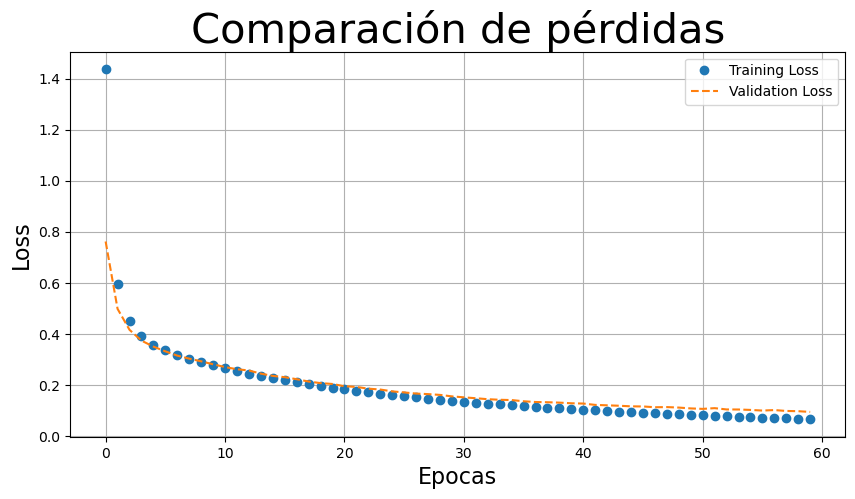

In [34]:
# Graficar las pérdidas
plt.figure(figsize=(10, 5))
plt.plot(train_losses_2, "o", label="Training Loss")
plt.plot(val_losses_2, "--", label="Validation Loss")

plt.ylabel("Loss", fontsize = 16)
plt.xlabel("Epocas", fontsize = 16)
plt.legend()
plt.title("Comparación de pérdidas", fontsize = 30)

plt.grid()
plt.show()

# Mezcla Dropout y L2

In [25]:
class NeuralNetwork_3(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork_3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout1(x)
        x = self.activation(self.fc2(x))
        x = self.dropout2(x)
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

In [26]:
# Función para entrenar el modelo con métricas y guardado del mejor modelo
def train_model_3(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()
        
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Evaluación en validación
        model_1.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        epoch_time = time.time() - start_time
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Time: {epoch_time:.2f}s")
        
        # Guardar el mejor modelo basado en pérdida de validación
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "Modelo_Combinado.pth")
            print("Model saved!")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [27]:
# Instanciar el modelo
input_size = 28 * 28
hidden_sizes = [512, 256, 128]
output_size = 10

model3 = NeuralNetwork_3(input_size, hidden_sizes, output_size)

# Configurar el optimizador y la función de pérdida

# Definir los parámetros del optimizador
learning_rate = 0.000005
beta_1 = 0.8
beta_2 = 0.999
epsilon = 1e-10

# Crear el optimizador Adam con los parámetros especificados
custom_optimizer = optim.Adam(model3.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=epsilon, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()  # Pérdida para clasificación

In [28]:
# Entrenar el modelo
epochs = 60
train_losses_3, val_losses_3, train_accuracies_3, val_accuracies_3 = train_model_3(model3, train_loader, val_loader, custom_optimizer, criterion, epochs)

Epoch 1/60 - Train Loss: 1.7663, Train Acc: 0.5325, Val Loss: 1.0921, Val Acc: 0.7128, Time: 59.55s
Model saved!
Epoch 2/60 - Train Loss: 0.8412, Train Acc: 0.7648, Val Loss: 0.6874, Val Acc: 0.8043, Time: 55.83s
Model saved!
Epoch 3/60 - Train Loss: 0.6072, Train Acc: 0.8211, Val Loss: 0.5502, Val Acc: 0.8387, Time: 55.04s
Model saved!
Epoch 4/60 - Train Loss: 0.5077, Train Acc: 0.8506, Val Loss: 0.4817, Val Acc: 0.8566, Time: 54.86s
Model saved!
Epoch 5/60 - Train Loss: 0.4533, Train Acc: 0.8671, Val Loss: 0.4403, Val Acc: 0.8725, Time: 55.77s
Model saved!
Epoch 6/60 - Train Loss: 0.4168, Train Acc: 0.8760, Val Loss: 0.4106, Val Acc: 0.8758, Time: 56.27s
Model saved!
Epoch 7/60 - Train Loss: 0.3893, Train Acc: 0.8845, Val Loss: 0.3871, Val Acc: 0.8842, Time: 54.88s
Model saved!
Epoch 8/60 - Train Loss: 0.3705, Train Acc: 0.8905, Val Loss: 0.3685, Val Acc: 0.8904, Time: 54.11s
Model saved!
Epoch 9/60 - Train Loss: 0.3507, Train Acc: 0.8961, Val Loss: 0.3488, Val Acc: 0.8967, Time: 54.

In [29]:
# Evaluar el modelo en el conjunto de prueba
accuracy_3 = evaluate_model(model3, test_loader, criterion)

Test Loss: 0.0857, Accuracy: 0.9733


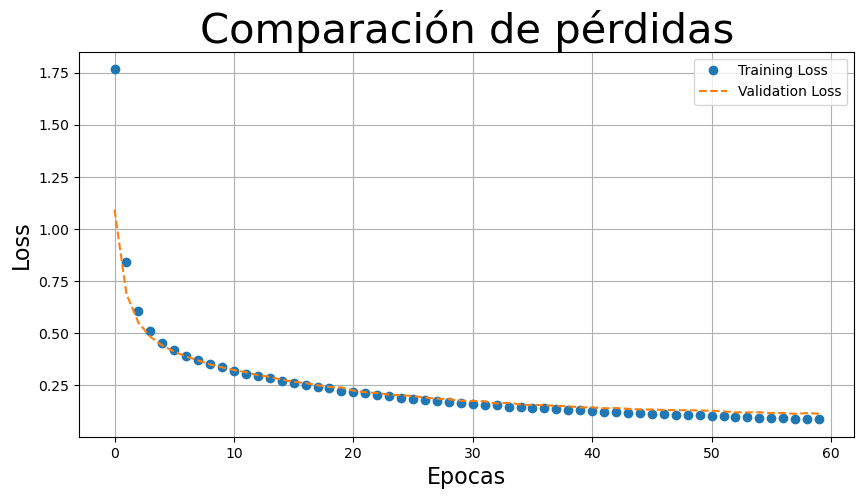

In [35]:
# Graficar las pérdidas
plt.figure(figsize=(10, 5))
plt.plot(train_losses_3, "o", label="Training Loss")
plt.plot(val_losses_3, "--", label="Validation Loss")

plt.ylabel("Loss", fontsize = 16)
plt.xlabel("Epocas", fontsize = 16)
plt.legend()
plt.title("Comparación de pérdidas", fontsize = 30)
plt.grid()
plt.show()

## Modificación de parámetros combinados

In [6]:
class NeuralNetwork_4(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork_4, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout1(x)
        x = self.activation(self.fc2(x))
        x = self.dropout2(x)
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

In [10]:
# Función para entrenar el modelo con métricas y guardado del mejor modelo
def train_model_4(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()
        
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Evaluación en validación
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        epoch_time = time.time() - start_time
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Time: {epoch_time:.2f}s")
        
        # Guardar el mejor modelo basado en pérdida de validación
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "Modelo_Combinado_2.pth")
            print("Model saved!")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [11]:
# Instanciar el modelo
input_size = 28 * 28
hidden_sizes = [512, 256, 128]
output_size = 10

model4 = NeuralNetwork_4(input_size, hidden_sizes, output_size)

# Configurar el optimizador y la función de pérdida

# Definir los parámetros del optimizador
learning_rate = 0.0001
beta_1 = 0.8
beta_2 = 0.999
epsilon = 1e-10

# Crear el optimizador Adam con los parámetros especificados
custom_optimizer = optim.Adam(model4.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=epsilon, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()  # Pérdida para clasificación

In [12]:
# Entrenar el modelo
epochs = 60
train_losses_4, val_losses_4, train_accuracies_4, val_accuracies_4 = train_model_4(model4, train_loader, val_loader, custom_optimizer, criterion, epochs)

Epoch 1/60 - Train Loss: 0.4974, Train Acc: 0.8455, Val Loss: 0.2405, Val Acc: 0.9264, Time: 61.36s
Model saved!
Epoch 2/60 - Train Loss: 0.2301, Train Acc: 0.9289, Val Loss: 0.1617, Val Acc: 0.9503, Time: 57.81s
Model saved!
Epoch 3/60 - Train Loss: 0.1730, Train Acc: 0.9468, Val Loss: 0.1429, Val Acc: 0.9574, Time: 58.07s
Model saved!
Epoch 4/60 - Train Loss: 0.1420, Train Acc: 0.9569, Val Loss: 0.1208, Val Acc: 0.9642, Time: 58.36s
Model saved!
Epoch 5/60 - Train Loss: 0.1258, Train Acc: 0.9610, Val Loss: 0.1066, Val Acc: 0.9668, Time: 55.53s
Model saved!
Epoch 6/60 - Train Loss: 0.1112, Train Acc: 0.9657, Val Loss: 0.1060, Val Acc: 0.9670, Time: 55.68s
Model saved!
Epoch 7/60 - Train Loss: 0.1016, Train Acc: 0.9683, Val Loss: 0.1002, Val Acc: 0.9704, Time: 63.48s
Model saved!
Epoch 8/60 - Train Loss: 0.0928, Train Acc: 0.9705, Val Loss: 0.0913, Val Acc: 0.9711, Time: 60.87s
Model saved!
Epoch 9/60 - Train Loss: 0.0867, Train Acc: 0.9731, Val Loss: 0.0870, Val Acc: 0.9741, Time: 58.

In [15]:
# Evaluar el modelo en el conjunto de prueba
accuracy_4 = evaluate_model(model4, test_loader, criterion)

Test Loss: 0.0674, Accuracy: 0.9829


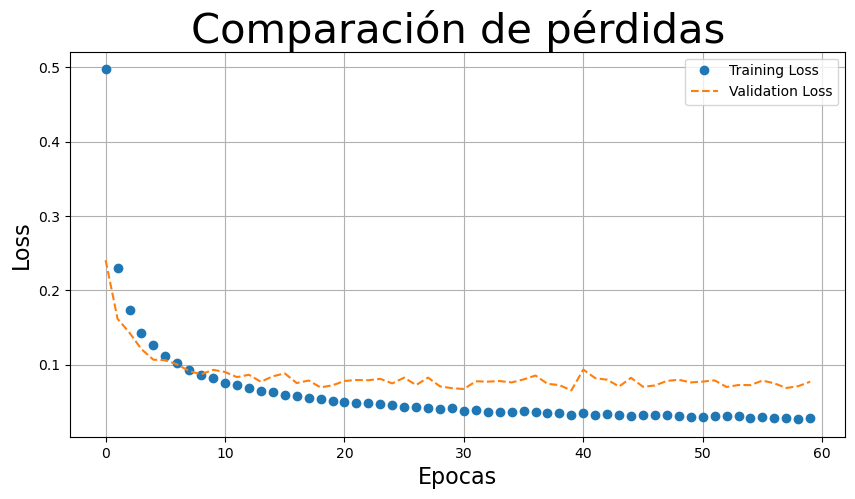

In [21]:
# Graficar las pérdidas
plt.figure(figsize=(10, 5))
plt.plot(train_losses_4, "o", label="Training Loss")
plt.plot(val_losses_4, "--", label="Validation Loss")

plt.ylabel("Loss", fontsize = 16)
plt.xlabel("Epocas", fontsize = 16)
plt.legend()
plt.title("Comparación de pérdidas", fontsize = 30)
plt.grid()
plt.show()

In [17]:
# Cargar el modelo
model_5 = NeuralNetwork_4(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size)
model_5.load_state_dict(torch.load('Modelo_Combinado_2.pth'))
model_5.eval()

C:\Users\jltg_\AppData\Local\Temp\ipykernel_10476\3167849070.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_5.load_state_dict(torch.load('Modelo_Combinado_2.pth')

NeuralNetwork_4(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (activation): ReLU()
)

In [20]:
# Evaluar el modelo
data_loader = ...  # Cargar tu DataLoader de prueba
evaluate_model(model_5,test_loader, criterion)

Test Loss: 0.0621, Accuracy: 0.9829


0.9829